In [43]:
from utils import load_series_dfs
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import os
from shapely import wkt, Point
import geopandas as gpd
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import pickle
import requests
from utils import load_series_dfs
from config.weather_params import WeatherParam
from datetime import datetime

In [44]:
gpkg_path = os.path.join('..', 'data', 'df_mapping_centroids.gpkg')
df_mapping = gpd.read_file(gpkg_path)

df_mapping.columns

Index(['nemesys_key', 'geom_g', 'centroid_lon', 'centroid_lat', 'geometry'], dtype='object')

In [45]:
# 1. Resource-ID für stündliche Klimastationen
resource_id = 'klima-v2-1h'

# 2. Metadata-Endpoint ansprechen
url_meta  = f"https://dataset.api.hub.geosphere.at/v1/station/historical/{resource_id}/metadata"
resp_meta = requests.get(url_meta)
resp_meta.raise_for_status()

# 3. Liste der Station-Dicts rausziehen
data = resp_meta.json()          # {'stations': [ {...}, {...}, … ]}
stations_list = data['stations']

# 4. In DataFrame umwandeln
stations_df = pd.DataFrame.from_records(stations_list)

# 5. Wichtige Spalten anzeigen
print("Spalten:", stations_df.columns.tolist())
print(stations_df[['id','name','lat','lon']].head())

Spalten: ['type', 'id', 'group_id', 'name', 'state', 'lat', 'lon', 'altitude', 'valid_from', 'valid_to', 'has_sunshine', 'has_global_radiation', 'is_active']
   id              name       lat       lon
0   1            Aflenz  47.54594  15.24069
1   2  Aigen im Ennstal  47.53278  14.13826
2   3       Allentsteig  48.69083  15.36694
3   4         Amstetten  48.10889  14.89500
4   5        Bad Aussee  47.61050  13.75844


In [46]:
df = pd.read_csv('../data/wetterdaten_top150_filled_linear.csv.gz', compression='gzip', parse_dates=['timestamp'])
df.head()

,timestamp,station_id,tl,rf,ff,ffx,cglo,so_h,rr,rrm,tb10,tb20
0,2014-01-01 00:00:00+00:00,2,-2.7,93.0,1.7,2.6,0.0,0.0,0.0,0.0,0.5,1.1
1,2014-01-01 00:00:00+00:00,7604,4.0,84.0,3.2,6.3,0.0,0.0,0.0,0.0,3.9,5.2
2,2014-01-01 00:00:00+00:00,48,1.5,88.0,0.9,2.2,0.0,0.0,0.0,0.0,3.0,3.7
3,2014-01-01 00:00:00+00:00,20412,1.4,100.0,0.2,1.5,0.0,0.0,0.0,0.0,2.8,3.2
4,2014-01-01 00:00:00+00:00,89,1.5,95.0,0.7,3.3,0.0,0.0,0.0,0.0,2.1,2.2


In [47]:
stations_df = stations_df.query('id in @df.station_id.unique()') #df.station_id.unique()

In [48]:
# Geometriedaten parsen und als GeoSeries setzen
df_mapping['geom_g'] = gpd.GeoSeries.from_wkt(df_mapping['geom_g'])

In [49]:
df_mapping = df_mapping.set_geometry('geom_g')

In [50]:
from shapely.geometry import Point, LineString, MultiLineString, Polygon, MultiPolygon

def interior_point(g):
    t = g.geom_type
    if t in ("Polygon", "MultiPolygon"):
        return g.representative_point()
    elif t in ("LineString", "MultiLineString"):
        return g.interpolate(0.5, normalized=True)
    elif t == "Point":
        return g
    else:
        return g.centroid

df_mapping['pt_interior'] = df_mapping['geom_g'].apply(interior_point)

In [51]:
# Quell-CRS richtig setzen
df_mapping = df_mapping.set_crs("EPSG:32633", allow_override=True)

# In Lon/Lat transformieren
df_wgs = df_mapping.to_crs(epsg=4326)

# Lon/Lat aus dem Innen-Punkt extrahieren
df_wgs['centroid_lon'] = df_wgs['pt_interior'].x
df_wgs['centroid_lat'] = df_wgs['pt_interior'].y

In [52]:
df_wgs[['centroid_lon', 'centroid_lat']]

,centroid_lon,centroid_lat
0,574298.473492,5.236470e+06
1,592254.428411,5.234861e+06
2,451102.757675,5.278928e+06
3,459558.991970,5.339463e+06
4,456008.641067,5.342558e+06
5,438565.004915,5.351961e+06
6,484911.136354,5.181469e+06
7,454988.377977,5.327099e+06
8,178961.587808,5.264391e+06
9,626005.942156,5.302132e+06


In [53]:
import geopandas as gpd

# 1. Für alle weiteren Schritte sicherstellen, dass df_mapping das richtige CRS hat
#    (falls noch nicht geschehen)
df_mapping = df_mapping.set_crs("EPSG:32633", allow_override=True)

# 2. Neue GeoDataFrame anlegen, wobei 'pt_interior' die aktive Geometrie wird
df_pts = gpd.GeoDataFrame(
    df_mapping.drop(columns='geometry'),  # alte geometry-Spalte entfernen, falls gewünscht
    geometry=df_mapping['pt_interior'],
    crs="EPSG:32633"
)

# 3. Jetzt transformierst Du df_pts in WGS84
df_pts = df_pts.to_crs(epsg=4326)

# 4. Longitude / Latitude aus der neuen Geometrie ziehen
df_pts['centroid_lon'] = df_pts.geometry.x
df_pts['centroid_lat'] = df_pts.geometry.y

# 5. Kontrolle
print(df_pts[['nemesys_key','centroid_lon','centroid_lat']].head())

   nemesys_key  centroid_lon  centroid_lat
0  FL_00025241     15.982384     47.277499
1  FL_00352191     16.219418     47.260741
2  FL_00020896     14.348744     47.661897
3  FL_00024730     14.455680     48.207108
4  FL_00024735     14.407575     48.234712


In [ ]:
df_pts[['nemesys_key','centroid_lon','centroid_lat']]

In [54]:
import numpy as np
from sklearn.neighbors import BallTree
import pandas as pd

# 1. Stations-Koordinaten in Radianten
coords_stat = np.deg2rad(stations_df[['lat','lon']].values)

# 2. Centroid-Interior-Koordinaten in Radianten
coords_map  = np.deg2rad(df_pts[['centroid_lat','centroid_lon']].values)

# 3. BallTree mit Haversine-Metrik bauen
tree = BallTree(coords_stat, metric='haversine')

# 4. Für jeden Centroid den nächsten Nachbarn suchen
dist_rad, idx = tree.query(coords_map, k=1)

# 5. In Kilometern umrechnen
dist_km = dist_rad.flatten() * 6371.0

# 6. Ergebnis-Tabelle zusammenbauen
result = pd.DataFrame({
    'nemesys_key':  df_pts['nemesys_key'].values,
    'stat_id':      stations_df.iloc[idx.flatten()]['id'].values,
    'stat_name':    stations_df.iloc[idx.flatten()]['name'].values,
    'dist_km':      dist_km
})

print(result.head())

   nemesys_key  stat_id         stat_name    dist_km
0  FL_00025241    13702         Bernstein  25.564926
1  FL_00352191    16800       Kleinzicken  10.030823
2  FL_00020896        2  Aigen im Ennstal  21.335927
3  FL_00024730       56        Linz Stadt  16.054068
4  FL_00024735       56        Linz Stadt  11.356925


In [55]:
result

,nemesys_key,stat_id,stat_name,dist_km
0,FL_00025241,13702,Bernstein,25.564926
1,FL_00352191,16800,Kleinzicken,10.030823
2,FL_00020896,2,Aigen im Ennstal,21.335927
3,FL_00024730,56,Linz Stadt,16.054068
4,FL_00024735,56,Linz Stadt,11.356925
5,FL_00352244,56,Linz Stadt,8.759799
6,FL_00352430,90,St.Andrä im Lavanttal,3.172349
7,FL_00024731,204,Kremsmünster,20.152225
8,FL_00352054,11402,Holzgau,37.324077
9,FL_00352189,7710,Seibersdorf,18.531680


In [56]:
result.dist_km.describe()

count    43.000000
mean     15.408752
std       8.969654
min       0.845504
25%       8.531397
50%      15.194802
75%      21.317700
max      37.324077
Name: dist_km, dtype: float64

In [ ]:
for key, df_e in series_dfs.items():
    # aus key das nemesys_key extrahieren (z.B. bis '.PLAN')
    nem_key = key.split(".PLAN")[0]

    # zugehörige station_id aus deinem Mapping
    stat = result.get(nem_key)
    print(stat)

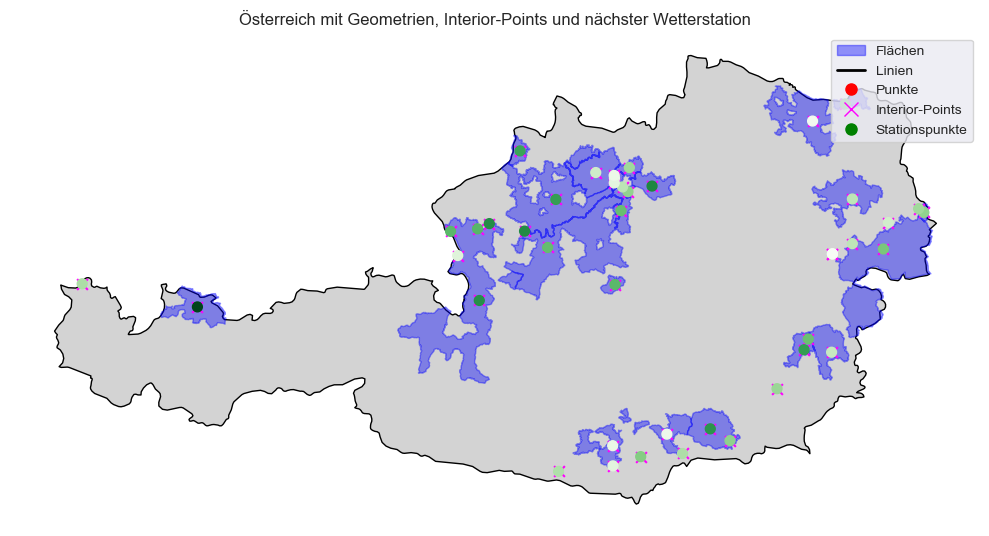

In [57]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# 1. GeoDataFrame aufbauen (EPSG:32633), direkt aus geom_g
gdf = gpd.GeoDataFrame(
    df_mapping,
    geometry='geom_g',
    crs='EPSG:32633'
)

# 2. Interior-Point berechnen
gdf['pt_interior'] = gdf.geometry.apply(
    lambda geom: (
        geom.representative_point() if geom.geom_type in ("Polygon","MultiPolygon")
        else geom.interpolate(0.5, normalized=True) if geom.geom_type in ("LineString","MultiLineString")
        else geom
    )
)

# 3. Österreich-Grenze via URL laden
countries_url = "https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson"
world        = gpd.read_file(countries_url)
austria      = world[world['name']=='Austria'].to_crs(gdf.crs)

# 4. Stations-GeoDataFrame erstellen und transformieren
stations_df_zoned = stations_df.query('id in @result.stat_id.unique()')
stations_gdf = (
    gpd.GeoDataFrame(
        stations_df_zoned,
        geometry=gpd.points_from_xy(stations_df_zoned.lon, stations_df_zoned.lat),
        crs='EPSG:4326'
    )
    .to_crs(gdf.crs)
)

# 5. Nächstgelegene Station per Spatial Join (inkl. Distanz in dist_m)
pts = gpd.GeoDataFrame(gdf, geometry='pt_interior', crs=gdf.crs)
joined = gpd.sjoin_nearest(
    pts, stations_gdf,
    how='left', distance_col='dist_m'
)

# 6. Plot-Layer splitten
polygons     = gdf[gdf.geom_type.isin(['Polygon','MultiPolygon'])]
lines        = gdf[gdf.geom_type.isin(['LineString','MultiLineString'])]
points       = gdf[gdf.geom_type=='Point']
pts_interior = pts.copy()

# 7. Plot
fig, ax = plt.subplots(figsize=(10,10))
austria.plot(ax=ax, color='lightgray', edgecolor='black', zorder=0)

polygons.plot(ax=ax, facecolor='blue', edgecolor='blue', alpha=0.4, zorder=1)
lines   .plot(ax=ax, color='black', linewidth=2,       zorder=2)
points  .plot(ax=ax, color='red',   markersize=20,     zorder=3)

pts_interior.plot(
    ax=ax,
    color='magenta',
    marker='x',
    markersize=60,
    zorder=4,
    label='Interior-Points'
)

joined.plot(
    ax=ax,
    column='dist_m',         # optional: farblich nach Distanz
    cmap='Greens',           # oder einfach feste Farbe
    marker='o',
    markersize=50,
    zorder=5,
    label='Nächstgelegene Wetterstation'
)

# 8. Legende
legend_elems = [
    Patch(facecolor='blue',   edgecolor='blue',  alpha=0.4, label='Flächen'),
    Line2D([0],[0], color='black', lw=2,   label='Linien'),
    Line2D([0],[0], marker='o', color='red',   linestyle='', markersize=8,  label='Punkte'),
    Line2D([0],[0], marker='x', color='magenta', linestyle='', markersize=10, label='Interior-Points'),
    Line2D([0],[0], marker='o', color='green',   linestyle='', markersize=8,  label='Stationspunkte'),
]
ax.legend(handles=legend_elems, loc='upper right')

ax.set_title("Österreich mit Geometrien, Interior-Points und nächster Wetterstation")
ax.set_axis_off()
plt.tight_layout()
plt.show()



In [58]:
series_dfs = load_series_dfs(data_dir=r"C:\Users\johan\Documents\FH_Master\data")

In [59]:
series_dfs.keys()

dict_keys(['FL_00024702.PLAN.MengeHH', 'FL_00024730.PLAN.MengeHH', 'FL_00352243.PLAN.MengeHH', 'FL_00352244.PLAN.MengeGA', 'FL_00352244.PLAN.MengeKW', 'FL_00024360.PLAN.MengeGA', 'FL_00352254.PLAN.MengeGA', 'FL_00025248.PLAN.MengeGA', 'FL_00024360.PLAN.MengeHH.2', 'FL_00024731.PLAN.MengeHH', 'FL_00024735.PLAN.MengeHH', 'FL_00024667.PLAN.MengeHH', 'FL_00352218.PLAN.MengeHH', 'FL_00025240.PLAN.MengeHH', 'FL_00025241.PLAN.MengeHH', 'FL_00020896.PLAN.MengeHH', 'FL_00342704.PLAN.MengeGA', 'FL_00352054.PLAN.MengeHH', 'CV_00348266.PLAN.Menge', 'FL_00352254.PLAN.MengeHH', 'FL_00352244.PLAN.MengeHH', 'FL_00342704.PLAN.MengeHH', 'CV_00003083.PLAN.Menge', 'CV_00003181.PLAN.Menge', 'CV_00003192.PLAN.Menge', 'CV_00003191.PLAN.Menge', 'CV_00003183.PLAN.Menge', 'CV_00001876.PLAN.Menge', 'CV_00003094.PLAN.Menge', 'CV_00003089.PLAN.Menge', 'CV_00007270.PLAN.Menge', 'CV_00007300.PLAN.Menge', 'KN_00001613.PLAN.Menge', 'KN_00000069.PLAN.Menge', 'KN_00000067.PLAN.Menge', 'CV_00007809.PLAN.Menge', 'FL_00352

In [60]:
series_dfs['FL_00024702.PLAN.MengeHH']

,consumption,hour,weekday,month,is_weekend
von | von,,,,,
2014-01-01 06:00:00,1.472,6,2,1,0
2014-01-01 07:00:00,1.517,7,2,1,0
2014-01-01 08:00:00,1.472,8,2,1,0
2014-01-01 09:00:00,1.517,9,2,1,0
2014-01-01 10:00:00,1.495,10,2,1,0
...,...,...,...,...,...
2018-12-31 19:00:00,32.223,19,0,12,0
2018-12-31 20:00:00,29.348,20,0,12,0
2018-12-31 21:00:00,24.727,21,0,12,0


In [ ]:
result

In [95]:
import requests
import pandas as pd

def fetch_and_fill_station(station_id, start, end):
    """
    Lädt stündliche Wetterparameter für eine gegebene Station (ohne API-Key)
    von Geosphere und füllt alle Lücken linear.

    Parameters:
    - station_id: int oder str, Stations-ID
    - start:      str oder pd.Timestamp, z.B. "2014-01-01T00:00"
    - end:        str oder pd.Timestamp, z.B. "2018-01-31T23:00"

    Returns:
    - pd.DataFrame, Index = timestamp, Spalten =
      ['tl','rf','ff','ffx','cglo','so_h','rr','rrm','tb10','tb20']
    """
    BASE_URL   = "https://dataset.api.hub.geosphere.at/v1/station/historical/klima-v2-1h"
    parameters = ["tl","rf","ff","ffx","cglo","so_h","rr","rrm","tb10","tb20"]
    params = {
        "station_ids": station_id,
        "parameters":  ",".join(parameters),
        "start":        pd.to_datetime(start).isoformat(),
        "end":          pd.to_datetime(end).isoformat()
    }

    # Request und JSON parsen
    r = requests.get(BASE_URL, params=params, timeout=90)
    r.raise_for_status()
    js = r.json()

    timestamps = js.get("timestamps", [])
    features   = js.get("features", [])
    if not features or not timestamps:
        raise ValueError(f"Keine Daten für Station {station_id}")

    # Parameter-Daten extrahieren
    param_data = features[0]["properties"]["parameters"]

    # DataFrame aufbauen
    df = pd.DataFrame(
        { p: param_data.get(p, {}).get("data", [])
          for p in parameters },
        index=pd.to_datetime(timestamps)
    )
    df.index.name = "timestamp"

    # Lücken linear nach Zeit interpolieren (auch an Rändern)
    df_filled = df.interpolate(method="time", limit_direction="both")

    return df_filled

def add_weather_via_api(df_energy, station_id):
    # 1) tz-naive Index
    df_e = df_energy.copy()
    df_e.index = pd.to_datetime(df_e.index).tz_localize(None)

    # 2) Wetterdaten laden & fill
    start, end = df_e.index.min(), df_e.index.max()
    df_w = fetch_and_fill_station(station_id, start, end)

    # Auch tz-naive
    df_w.index = df_w.index.tz_localize(None)
    df_w = df_w.reindex(df_e.index)
    df_w = df_w.add_prefix("w_")

    # 3) Alte w_-Spalten entfernen, falls schon vorhanden
    weather_cols = [c for c in df_e.columns if c.startswith("w_")]
    if weather_cols:
        df_e = df_e.drop(columns=weather_cols)

    # 4) Join
    return df_e.join(df_w)
# # --- 4. Energiedaten laden und anreichern ---
# #series_dfs = pd.read_pickle('/pfad/zu/deinen/energy_series.pkl')
#
for key, df_e in series_dfs.items():
    nem_key = key.split('.PLAN')[0]
    if nem_key not in mapping:
        print(f"⚠️ Kein Eintrag in result für {nem_key}, übersprungen.")
        continue
    stat_id = mapping[nem_key]
    df_e.index = pd.to_datetime(df_e.index)
    series_dfs[key] = add_weather_via_api(df_e, stat_id)
    print(key)


FL_00024702.PLAN.MengeHH
FL_00024730.PLAN.MengeHH
FL_00352243.PLAN.MengeHH
FL_00352244.PLAN.MengeGA
FL_00352244.PLAN.MengeKW
FL_00024360.PLAN.MengeGA
FL_00352254.PLAN.MengeGA
FL_00025248.PLAN.MengeGA
FL_00024360.PLAN.MengeHH.2
FL_00024731.PLAN.MengeHH
FL_00024735.PLAN.MengeHH
FL_00024667.PLAN.MengeHH
FL_00352218.PLAN.MengeHH
FL_00025240.PLAN.MengeHH
FL_00025241.PLAN.MengeHH
FL_00020896.PLAN.MengeHH
FL_00342704.PLAN.MengeGA
FL_00352054.PLAN.MengeHH
CV_00348266.PLAN.Menge
FL_00352254.PLAN.MengeHH
FL_00352244.PLAN.MengeHH
FL_00342704.PLAN.MengeHH
CV_00003083.PLAN.Menge
CV_00003181.PLAN.Menge
CV_00003192.PLAN.Menge
CV_00003191.PLAN.Menge
CV_00003183.PLAN.Menge
CV_00001876.PLAN.Menge
CV_00003094.PLAN.Menge
CV_00003089.PLAN.Menge
CV_00007270.PLAN.Menge
CV_00007300.PLAN.Menge
KN_00001613.PLAN.Menge
KN_00000069.PLAN.Menge
KN_00000067.PLAN.Menge
CV_00007809.PLAN.Menge
FL_00352191.PLAN.MengeHH
FL_00352189.PLAN.MengeHH
KN_00001886.PLAN.Menge
KN_00001602.PLAN.Menge
FL_00352430.PLAN.MengeHH
FL_0035

In [96]:
series_dfs['FL_00024702.PLAN.MengeHH']

,consumption,hour,weekday,month,is_weekend,w_tl,w_rf,w_ff,w_ffx,w_cglo,w_so_h,w_rr,w_rrm,w_tb10,w_tb20
von | von,,,,,,,,,,,,,,,
2014-01-01 06:00:00,1.472,6,2,1,0,2.1,88.0,1.0,3.0,0.0,0.0,0.0,0.0,3.3,3.3
2014-01-01 07:00:00,1.517,7,2,1,0,2.1,88.0,1.0,3.0,0.0,0.0,0.0,0.0,3.3,3.3
2014-01-01 08:00:00,1.472,8,2,1,0,2.2,87.0,1.1,3.1,13.0,0.0,0.0,0.0,3.3,3.3
2014-01-01 09:00:00,1.517,9,2,1,0,2.2,84.0,1.4,4.0,63.0,0.0,0.0,0.0,3.3,3.3
2014-01-01 10:00:00,1.495,10,2,1,0,2.7,79.0,1.2,3.7,144.0,0.3,0.0,0.0,3.3,3.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,32.223,19,0,12,0,3.9,95.0,0.6,3.2,0.0,0.0,0.0,0.0,4.0,3.3
2018-12-31 20:00:00,29.348,20,0,12,0,3.9,96.0,0.3,3.4,0.0,0.0,0.0,0.0,4.0,3.3
2018-12-31 21:00:00,24.727,21,0,12,0,3.9,96.0,0.5,2.6,0.0,0.0,0.0,2.0,4.0,3.3


In [98]:
# Angenommen, series_dfs ist schon geladen
summary = []
for key, df in series_dfs.items():
    total = df.size
    nan   = df.isna().sum().sum()
    summary.append({
        'series_key': key,
        'nan_count': nan,
        'total_cells': total,
        'percent_nan': nan/total
    })

summary_df = pd.DataFrame(summary)

# 1) Kurz anschauen
print(summary_df)

# 2) Nur jene Serien mit NaNs filtern
print(summary_df[summary_df['nan_count']>0])

# 3) In Datei schreiben, wenn du willst
summary_df.to_csv('nan_overview.csv', index=False)

                    series_key  nan_count  total_cells  percent_nan
0     FL_00024702.PLAN.MengeHH          0       658320          0.0
1     FL_00024730.PLAN.MengeHH          0       658320          0.0
2     FL_00352243.PLAN.MengeHH          0       658320          0.0
3     FL_00352244.PLAN.MengeGA          0       658320          0.0
4     FL_00352244.PLAN.MengeKW          0       658320          0.0
5     FL_00024360.PLAN.MengeGA          0       658320          0.0
6     FL_00352254.PLAN.MengeGA          0       658320          0.0
7     FL_00025248.PLAN.MengeGA          0       658320          0.0
8   FL_00024360.PLAN.MengeHH.2          0       658320          0.0
9     FL_00024731.PLAN.MengeHH          0       658320          0.0
10    FL_00024735.PLAN.MengeHH          0       658320          0.0
11    FL_00024667.PLAN.MengeHH          0       658320          0.0
12    FL_00352218.PLAN.MengeHH          0       658320          0.0
13    FL_00025240.PLAN.MengeHH          0       

In [99]:
pd.to_pickle(series_dfs, "../data/energy_with_weather.pkl")